In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/ slices_output1.zip"


In [ ]:
import zipfile
with zipfile.ZipFile(" slices_output1.zip", 'r') as zip_ref:
    zip_ref.extractall(" slices_output1")


In [ ]:
import os

train_dir = " slices_output1"
normal_count = len(os.listdir(os.path.join(train_dir, "normal")))
abnormal_count = len(os.listdir(os.path.join(train_dir, "abnormal")))

print(f"Normal: {normal_count}")
print(f"Abnormal: {abnormal_count}")


Normal: 54819
Abnormal: 41703


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Class mapping: {'abnormal': 0, 'normal': 1}
Found 77217 validated image filenames.
Found 9652 validated image filenames.
Found 9653 validated image filenames.
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🔹 Training head only...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.5039 - auc: 0.5048 - loss: 0.8793 - precision: 0.5699 - recall: 0.4975
Epoch 1: val_auc improved from -inf to 0.49802, saving model to /content/drive/MyDrive/best_model_by_auc_80_10_10.keras
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 2134s 858ms/step - accuracy: 0.5039 - auc: 0.5048 - loss: 0.8792 - precision: 0.5699 - recall: 0.4975 - val_accuracy: 0.4324 - val_auc: 0.4980 - val_loss: 0.7271 - val_precision: 0.5769 - val_recall: 0.0027 - learning_rate: 2.9932e-04
Epoch 2/3
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.5011 - auc: 0.5003 - loss: 0.7271 - precision: 0.5669 - recall: 0.5066
Epoch 2: val_auc improved from 0.49802 to 0.49975, saving model to /content/drive/MyDrive/best_model_by_auc_80_10_10.keras
2414/2414 ━━━━━━━━━━━━━━━━━━━━ 2011s 833ms/step - accuracy: 0.5011 - auc: 0.5003 - loss: 0.7271 - precision: 0.5669 - recall: 0.5066 - val_accuracy: 0.4320 - val_auc: 0.4997 - val_loss: 0.7174 - val_precision: 0

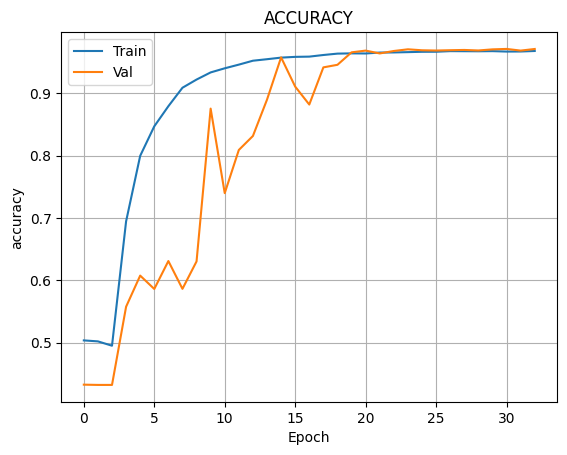

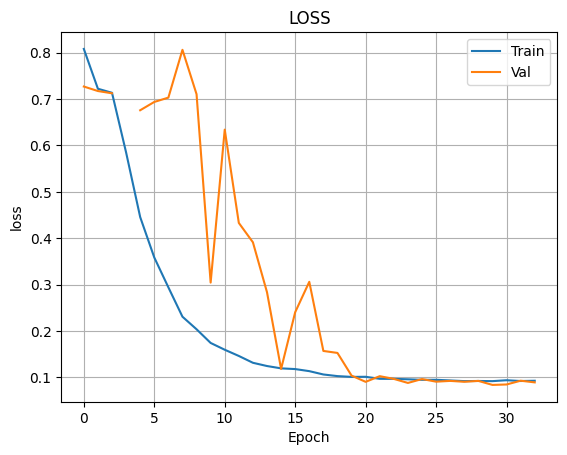

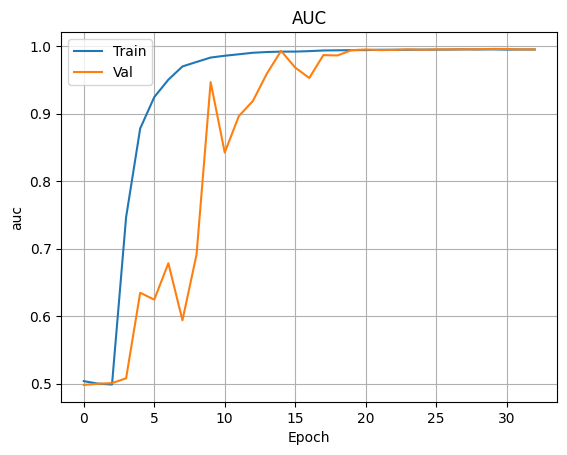

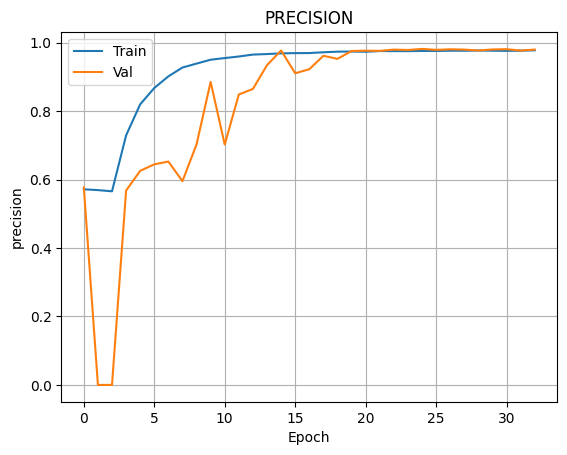

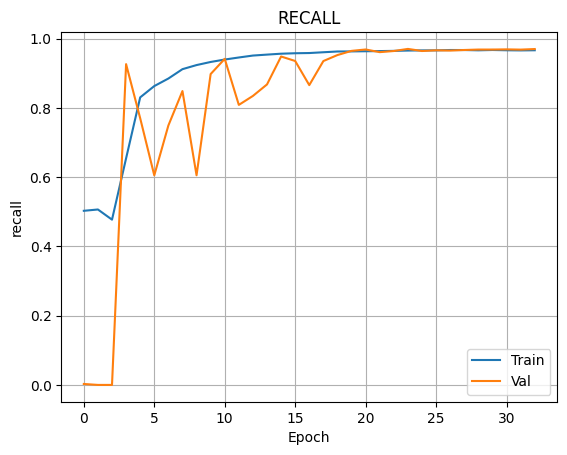

📊 Evaluating model on test set...
302/302 ━━━━━━━━━━━━━━━━━━━━ 255s 843ms/step - accuracy: 0.9687 - auc: 0.9957 - loss: 0.0908 - precision: 0.9788 - recall: 0.9655
✅ Test Accuracy : 0.9690
✅ Test AUC      : 0.9956
✅ Test Precision: 0.9793
✅ Test Recall   : 0.9659


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras import mixed_precision
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Enable mixed precision for A100 (faster and more memory-efficient)
mixed_precision.set_global_policy('mixed_float16')

# Parameters
IMG_SIZE     = (300, 300)
BATCH_SIZE   = 32
EPOCHS_HEAD  = 3
EPOCHS_FINE  = 30
TOTAL_EPOCHS = EPOCHS_HEAD + EPOCHS_FINE
DATA_DIR     = '/content/ slices_output1'
HEAD_LR      = 3e-4
FINE_TUNE_LR = 1e-4
DRIVE_PATH   = '/content/drive/MyDrive'

# --- Prepare file list ---
class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
mapping = {name: idx for idx, name in enumerate(class_names)}
print("Class mapping:", mapping)

filepaths, labels = [], []
for name in class_names:
    for fname in os.listdir(os.path.join(DATA_DIR, name)):
        filepaths.append(os.path.join(DATA_DIR, name, fname))
        labels.append(mapping[name])

df = pd.DataFrame({'filename': filepaths, 'label': labels})

# --- Split: 80% train, 10% val, 10% test ---
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

# Data Generators
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.1,
    brightness_range=(0.8,1.2),
    channel_shift_range=20.0,
    horizontal_flip=True,
    fill_mode='reflect'
)

train_gen = datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='raw', shuffle=True
)

val_gen = datagen.flow_from_dataframe(
    val_df, x_col='filename', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='raw', shuffle=True
)

test_gen = datagen.flow_from_dataframe(
    test_df, x_col='filename', y_col='label',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='raw', shuffle=False
)

# Compute steps dynamically (to avoid training crash)
STEPS_PER_EPOCH  = math.ceil(train_gen.n / BATCH_SIZE)
VALIDATION_STEPS = math.ceil(val_gen.n / BATCH_SIZE)

# Class weights
cw_array     = compute_class_weight('balanced', classes=np.unique(train_df['label']), y=train_df['label'])
class_weight = dict(enumerate(cw_array))

# Build Model
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.SpatialDropout2D(0.3),
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

# Optimizer + Metrics
lr_schedule = CosineDecay(initial_learning_rate=HEAD_LR, decay_steps=TOTAL_EPOCHS * STEPS_PER_EPOCH)
optimizer   = Adam(learning_rate=lr_schedule)
metrics     = ['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]

# Callbacks
checkpoint = ModelCheckpoint(
    os.path.join(DRIVE_PATH, 'best_model_by_auc_80_10_10.keras'),
    monitor='val_auc', mode='max', save_best_only=True, verbose=1
)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
early_stop = EarlyStopping(monitor='val_auc', mode='max', patience=5, restore_best_weights=True, verbose=1)

# Compile & Train Head
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=metrics)
print("🔹 Training head only...")
history_head = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_HEAD,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    class_weight=class_weight,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

# Fine-Tune Full Model
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=FINE_TUNE_LR), loss='binary_crossentropy', metrics=metrics)

print("🔓 Fine-tuning full model...")
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    initial_epoch=EPOCHS_HEAD,
    epochs=TOTAL_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    class_weight=class_weight,
    callbacks=[checkpoint, reduce_lr, early_stop]
)

# Combine History
full_history = {
    k: history_head.history[k] + history_fine.history[k]
    for k in history_head.history if k in history_fine.history
}

# Save Final Model
model.save(os.path.join(DRIVE_PATH, 'final_efficientnetB3_80_10_10.keras'))

# Plotting
def plot_history(hist):
    for m in ['accuracy', 'loss', 'auc', 'precision', 'recall']:
        plt.figure()
        plt.plot(hist[m], label='Train')
        plt.plot(hist[f'val_{m}'], label='Val')
        plt.title(m.upper())
        plt.xlabel('Epoch')
        plt.ylabel(m)
        plt.legend()
        plt.grid(True)
        plt.show()

plot_history(full_history)

# Evaluate on Test Set
print("📊 Evaluating model on test set...")
test_loss, test_acc, test_auc, test_prec, test_rec = model.evaluate(test_gen)
print(f"✅ Test Accuracy : {test_acc:.4f}")
print(f"✅ Test AUC      : {test_auc:.4f}")
print(f"✅ Test Precision: {test_prec:.4f}")
print(f"✅ Test Recall   : {test_rec:.4f}")
